### Define Tool and Model

In [1]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()


model = init_chat_model(
    "openai:gpt-3.5-turbo",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

c:\Users\aniln\miniconda3\envs\channel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tools

[StructuredTool(name='add', description='Adds `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000001B2347F8E00>),
 StructuredTool(name='multiply', description='Multiply `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001B2347E5800>),
 StructuredTool(name='divide', description='Divide `a` and `b`.\n\n    Args:\n        a: First int\n        b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000001B2348CCA40>)]

## Define state

In [3]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

## Define Model Mode

In [5]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    # response = model.bind_tools(tools).invoke(state["messages"])
    # return {"messages": response}
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

### Define Tool Node

In [6]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

## Define End Logic

In [27]:
## The conditional edge function is used to route to the tool node or end based upon whether the LLM made a tool call.

In [7]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

###  Build and compile the agent

In [29]:
### Here two method for using tool with model and make in graph
# 1. Using custom tool node function (tool_node)
# 2. Using prebuilt ToolNode from langgraph.prebuilt

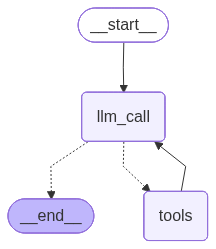

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
# agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node(ToolNode(tools))


# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
# agent_builder.add_conditional_edges(
#     "llm_call",
#     should_continue,
#     ["tool_node", END]
# )
agent_builder.add_conditional_edges(
    "llm_call",
    tools_condition,
)

# agent_builder.add_edge("tool_node", "llm_call")
agent_builder.add_edge("tools", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [11]:
# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4 and multiply by 10.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4 and multiply by 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_ygCewZRJvCUPyIQVTpKCNHSD)
 Call ID: call_ygCewZRJvCUPyIQVTpKCNHSD
  Args:
    a: 3
    b: 4
  multiply (call_9OpZ0hG03V0uADQ8F8GntkRE)
 Call ID: call_9OpZ0hG03V0uADQ8F8GntkRE
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

70
================================== Ai Message ==================================

The sum of 3 and 4 is 7, and when multiplied by 10, the result is 70.
